# Gridspace-Stanford Harper Valley transcript dataset

This notebook focuses on the use of the Gridspace-Stanford Harper Valley transcripts to use embeddings, visualizations, classifiers and chatbots.

**Optional for Colab users**

In [1]:
import os
from google.colab import drive

# # Mount drive and change directory
drive.mount('/content/drive')

path = 'NLP-Proyecto'
os.chdir(f'/content/drive/MyDrive/{path}')
datarepo = 'gridspace_repo/data/transcript'

Mounted at /content/drive


## Data Retrieval

The information related to the audios are stored in multiple json files, containing:


*   Machine Generated Transcript
*   Human Revised Transcript
*   Dialog Acts
*   Emotion detected (softmax output of a ML classifier)



In [2]:
import json
import pandas as pd

In [ ]:
data = []

for filename in os.listdir(datarepo):
    if filename.endswith('.json'):
        file_path = os.path.join(datarepo, filename)
        with open(file_path, 'r') as file:
            contents = json.load(file)
            for content in contents:
                emotions = content.get('emotion', {})
                neutral = emotions.get('neutral', None)
                negative = emotions.get('negative', None)
                positive = emotions.get('positive', None)
                data.append({
                    'identifier': filename[:-5],
                    'human_transcript': content['human_transcript'],
                    'machine_transcript': content['transcript'],
                    'dialog_acts': content['dialog_acts'],
                    'emotion_neutral': neutral,
                    'emotion_negative': negative,
                    'emotion_positive': positive,
                    'index': content['index'],
                    'speaker_role': content['speaker_role']
                })
df = pd.DataFrame(data)
df.to_csv('TranscriptDB.csv', index=False)

In [3]:
df = pd.read_csv('TranscriptDB.csv')
df.head(10)

,identifier,human_transcript,machine_transcript,dialog_acts,emotion_neutral,emotion_negative,emotion_positive,index,speaker_role
0,9691bca74ef140d0,hello this is harper valley national bank my n...,hello this is harper valley national bank my n...,['gridspace_greeting'],0.309475,0.015957,0.674568,1,agent
1,9691bca74ef140d0,hi my name is michael williams,hi my name is michael williams,"['gridspace_data_communication', 'gridspace_gr...",0.317042,0.036193,0.646765,2,caller
2,9691bca74ef140d0,i would like to reset my password,i would like to reset my password,"['gridspace_yes_response', 'gridspace_problem_...",0.553823,0.278830,0.167346,3,caller
3,9691bca74ef140d0,i'm happy to help you with that,i'm happy to help you with that,['gridspace_other'],0.345135,0.052922,0.601943,4,agent
4,9691bca74ef140d0,and what is your phone number,and what is your phone number,['gridspace_data_question'],0.560032,0.199025,0.240943,5,agent
5,9691bca74ef140d0,my phone number is zero one three,my phone number is zero one three,['gridspace_data_response'],0.584506,0.275289,0.140205,6,caller
6,9691bca74ef140d0,four four eight,four four eight,['gridspace_data_response'],0.582787,0.224562,0.192652,7,caller
7,9691bca74ef140d0,six eight three nine,six eight three nine,['gridspace_data_response'],0.602211,0.188286,0.209503,8,caller
8,9691bca74ef140d0,[noise],[noise],['gridspace_confirm_data'],1.000000,0.000000,0.000000,9,agent
9,9691bca74ef140d0,can you repeat the final four numbers of your ...,can you repeat the final four numbers of your ...,['gridspace_data_question'],0.481985,0.070061,0.447953,10,agent


###Cleaning
The data choosed to work with is the Human Revised transcript, but is noted that some records are missing along with a notation for events during the phone call (as [noise] or [dog]), therefore its needed to clean the dataframe

In [4]:
df.isna().sum()

identifier              0
human_transcript      349
machine_transcript      0
dialog_acts             0
emotion_neutral         0
emotion_negative        0
emotion_positive        0
index                   0
speaker_role            0
dtype: int64

In [5]:
df['human_transcript'] = df['human_transcript'].fillna(df['machine_transcript'])
df.isna().sum(), df.size

(identifier            0
 human_transcript      0
 machine_transcript    0
 dialog_acts           0
 emotion_neutral       0
 emotion_negative      0
 emotion_positive      0
 index                 0
 speaker_role          0
 dtype: int64,
 231570)

In [6]:
unique_words = set(word for sublist in df['human_transcript'].str.findall(r'\[([^\]]+)\]').dropna() for word in sublist)

print(unique_words)

{'dogs', 'noise', 'music', 'cough', 'unintelligible', 'laughter', 'kids', 'baby', 'ringing'}


In [7]:
pattern = r'(\[(' + '|'.join(unique_words) + r')\])|\<unk\>'

df['human_transcript'] = df['human_transcript'].replace(to_replace=pattern, value='', regex=True).str.strip()

df.drop(df[df['human_transcript'] == ''].index, inplace=True)

df.head(10)

,identifier,human_transcript,machine_transcript,dialog_acts,emotion_neutral,emotion_negative,emotion_positive,index,speaker_role
0,9691bca74ef140d0,hello this is harper valley national bank my n...,hello this is harper valley national bank my n...,['gridspace_greeting'],0.309475,0.015957,0.674568,1,agent
1,9691bca74ef140d0,hi my name is michael williams,hi my name is michael williams,"['gridspace_data_communication', 'gridspace_gr...",0.317042,0.036193,0.646765,2,caller
2,9691bca74ef140d0,i would like to reset my password,i would like to reset my password,"['gridspace_yes_response', 'gridspace_problem_...",0.553823,0.278830,0.167346,3,caller
3,9691bca74ef140d0,i'm happy to help you with that,i'm happy to help you with that,['gridspace_other'],0.345135,0.052922,0.601943,4,agent
4,9691bca74ef140d0,and what is your phone number,and what is your phone number,['gridspace_data_question'],0.560032,0.199025,0.240943,5,agent
5,9691bca74ef140d0,my phone number is zero one three,my phone number is zero one three,['gridspace_data_response'],0.584506,0.275289,0.140205,6,caller
6,9691bca74ef140d0,four four eight,four four eight,['gridspace_data_response'],0.582787,0.224562,0.192652,7,caller
7,9691bca74ef140d0,six eight three nine,six eight three nine,['gridspace_data_response'],0.602211,0.188286,0.209503,8,caller
9,9691bca74ef140d0,can you repeat the final four numbers of your ...,can you repeat the final four numbers of your ...,['gridspace_data_question'],0.481985,0.070061,0.447953,10,agent
10,9691bca74ef140d0,six eight three nine,six eight three nine,['gridspace_data_response'],0.604004,0.187679,0.208318,11,caller


In [8]:
len(df)

19599

##Data exploration


###Documents statistics
The dataset can be splited into documents grouping sentences belonging to calls, this will allow to see statistics regarding the length and vocab size average across all documents  

In [9]:
docs = df.groupby('identifier')['human_transcript'].apply(list).tolist()
docs[:2]

[['hello this is harper valley national bank',
  'my name is elizabeth',
  'how can i help you today',
  'hi',
  'my name is patricia brown',
  'i lost my debit card',
  'can you send me a new one',
  'which card would you like to replace',
  'my',
  'debit card',
  'can you repeat that please',
  'yes',
  'my debit card',
  'is there anything else i can help you with today',
  'no that was going to be it',
  'thank you for calling have a great day',
  'bye'],
 ['hello this is harper valley national bank my name is robert how can i help you today',
  'hi my name is mary smith',
  'i lost my credit card',
  'can you send me a new one',
  'sure i can help you with that',
  'uh which card would you like to replace',
  'my credit card',
  'okay so i have ordered your replacement credit card and you should be able to receive it in three to five business days',
  'is there anything else i can help you with',
  'no that was gonna be it',
  'thank you for calling have a great day',
  'bye']]

In [10]:
avg_words = 0
avg_vocab = 0

for doc in docs:
    words = [word for sentence in doc for word in sentence.split()]
    avg_words += len(words)
    avg_vocab += len(set(words))

avg_words /= len(docs)
avg_vocab /= len(docs)

print(f"The average count of words in each document is: {avg_words:.1f}\nWhile the average vocab length is: {avg_vocab:.1f}")

The average count of words in each document is: 95.7
While the average vocab length is: 58.6


###Vocabulary
The size of and the vocabulary of all the docs can be verified after cleaning the sentences from punctuation and conting different words

In [11]:
import re
from pandas.core.common import flatten

tokenized_sentences = [re.sub(r'\W+', ' ', re.sub(r"\'", '', sentence)).lower().split()  for sentence in df["human_transcript"].values]
sentences = list(flatten(tokenized_sentences))

vocab = sorted(set(sentences))
print(vocab)
print("Size of Vocab: "+str(len(vocab)))

['a', 'able', 'about', 'absolutely', 'acc', 'account', 'accounts', 'actually', 'address', 'addresses', 'after', 'afternoon', 'again', 'ah', 'ahead', 'all', 'almost', 'already', 'alright', 'alrighty', 'also', 'am', 'amanda', 'amount', 'amounts', 'an', 'and', 'animals', 'another', 'any', 'anymore', 'anyone', 'anything', 'apologize', 'apply', 'appointment', 'appointments', 'appreciate', 'are', 'area', 'around', 'arranged', 'arrive', 'arriving', 'as', 'ask', 'asked', 'asking', 'assist', 'associated', 'at', 'available', 'away', 'awesome', 'back', 'bada', 'balance', 'balances', 'bank', 'barry', 'be', 'beautiful', 'because', 'bedtime', 'been', 'before', 'beginning', 'behalf', 'believe', 'best', 'between', 'bill', 'bing', 'book', 'books', 'boom', 'branch', 'branches', 'broke', 'brought', 'brown', 'brunch', 'bunch', 'business', 'but', 'by', 'bye', 'c', 'calendar', 'cali', 'california', 'call', 'called', 'calling', 'can', 'cancel', 'canceled', 'cannot', 'cant', 'car', 'card', 'care', 'case', 'ca

###Words Frequency
To gain some insight in the dataset the words frequency can be calculated, but it might be useless unless you remove stop words that compose the most of the words in the data.

In [12]:
import nltk
counts = nltk.Counter(sentences)
counts.most_common(10)

[('is', 8119),
 ('you', 7940),
 ('i', 4866),
 ('my', 4615),
 ('can', 3407),
 ('help', 3051),
 ('name', 3048),
 ('a', 2799),
 ('thank', 2635),
 ('to', 2529)]

In [13]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
from nltk.corpus import stopwords

words_nostopwords = [w for w in sentences if w not in stopwords.words('english')]
counts_nostopwords = nltk.Counter(words_nostopwords)
counts_nostopwords.most_common(10)

[('help', 3051),
 ('name', 3048),
 ('thank', 2635),
 ('today', 1987),
 ('account', 1702),
 ('valley', 1669),
 ('harper', 1662),
 ('okay', 1659),
 ('day', 1600),
 ('hello', 1525)]

In [15]:
vocab_nonstop = sorted(set(words_nostopwords))
print("Size of Vocab without nonstop words: "+str(len(vocab_nonstop)))

Size of Vocab without nonstop words: 639


##Embeddings

The dataset will be explored with embeddings, specifically, using Word2Vec and Fast-text.
For this, the data should be splited into sentences (already done) and each sentence tokenized.

In [16]:
import re

tokenized = [sentence for sentence in tokenized_sentences if len(sentence) > 1]

for sentence in tokenized[:10]:
    print(sentence)

['hello', 'this', 'is', 'harper', 'valley', 'national', 'bank', 'my', 'name', 'is', 'james', 'how', 'can', 'i', 'help', 'you', 'today']
['hi', 'my', 'name', 'is', 'michael', 'williams']
['i', 'would', 'like', 'to', 'reset', 'my', 'password']
['im', 'happy', 'to', 'help', 'you', 'with', 'that']
['and', 'what', 'is', 'your', 'phone', 'number']
['my', 'phone', 'number', 'is', 'zero', 'one', 'three']
['four', 'four', 'eight']
['six', 'eight', 'three', 'nine']
['can', 'you', 'repeat', 'the', 'final', 'four', 'numbers', 'of', 'your', 'phone', 'number', 'please']
['six', 'eight', 'three', 'nine']


In [17]:
len(tokenized_sentences)

19599

Finally we have the data in the right format for training Word2Vec/FastText, so we can provide it to the algorithm. For parameters, we set:
- the embedding size to be 50,
- the minimum count for any vocabulary term to be 2 as we have a small vocab
- the size of the context window to 10.

In [18]:
!pip install --upgrade gensim

In [29]:
from gensim.models import Word2Vec, FastText

model_WV = Word2Vec(vector_size=50, window=10, min_count=4, sentences=tokenized_sentences, epochs=10)
model_FT = FastText(vector_size=50, window=10, min_count=4, sentences=tokenized_sentences, epochs=10)

The vocab learned is small, as the dataset is not big and is composed of by a specific task.

In [30]:
len(model_WV.wv), len(model_FT.wv)

(395, 395)

### Inspecting embeddings
Its remarkable that whether Word2vec can only use words presented during training, FastText can also different ones



In [31]:
term = 'help'

try:
  print(model_WV.wv.most_similar(term)[:3])
except Exception as e:
  print(e)
print(model_FT.wv.most_similar(term)[:3])

[('can', 0.5684390068054199), ('assist', 0.5332887768745422), ('is', 0.5020341873168945)]
[('helpful', 0.9060781002044678), ('hear', 0.7105252146720886), ('here', 0.6761425137519836)]


In [32]:
term = 'banking'

try:
  print(model_WV.wv.most_similar(term)[:3])
except Exception as e:
  print(e)
print(model_FT.wv.most_similar(term)[:3])

"Key 'banking' not present in vocabulary"
[('bank', 0.676230788230896), ('checking', 0.6284130215644836), ('savings', 0.6205735802650452)]


###Embedding visualization (tSNE)

As the vocab learned is pretty small (512 words) all can be included in the visualization, for which a TSNE model needs to be fited to the data and then converted in 3D coordinates



In [33]:
from sklearn.manifold import TSNE
import numpy as np

word_vectors_WV = model_WV.wv[list(model_WV.wv.key_to_index)]
word_vectors_FT = model_FT.wv[list(model_FT.wv.key_to_index)]

tsne = TSNE(n_components=3, n_iter=2000)
tsne_embeddingWV = tsne.fit_transform(word_vectors_WV)
tsne_embeddingFT = tsne.fit_transform(word_vectors_FT)

x, y, z = np.transpose(tsne_embeddingWV)
x2, y2, z2 = np.transpose(tsne_embeddingFT)

And generate the 3d plot:

In [34]:
!pip install -q plotly
import plotly.express as px

In [35]:
fig = px.scatter_3d(x=x[:200],y=y[:200],z=z[:200],text=list(model_WV.wv.key_to_index)[:200])
fig.update_traces(marker=dict(size=3,line=dict(width=2)),textfont_size=10)
fig.show()

Words regarding the welcome are grouped together, the same as words used to get some time...
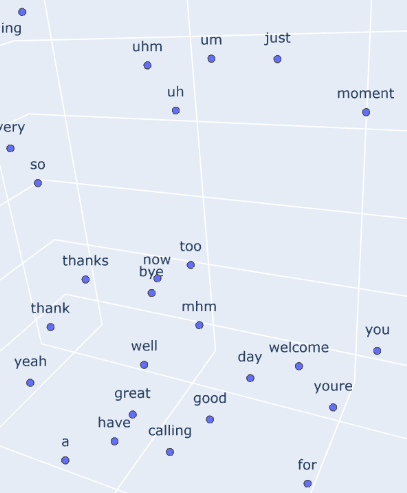

In [26]:
fig = px.scatter_3d(x=x2[:200],y=y2[:200],z=z2[:200],text=list(model_FT.wv.key_to_index)[:200])
fig.update_traces(marker=dict(size=3,line=dict(width=2)),textfont_size=10)
fig.show()